In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 12.1.0


# Doppler Radar

## Introduction

A Doppler radar is a specialized type of radar system that is used to detect the movement of objects by utilizing the Doppler effect. The Doppler effect is a phenomenon in physics where the frequency of a wave (such as sound or radio waves) changes when the source of the wave and the observer are in relative motion. In the context of radar, the Doppler effect is employed to measure the velocity of objects, typically in the form of moving targets like vehicles, aircraft, weather phenomena, or even celestial bodies like planets.

Doppler radar systems emit electromagnetic waves, often in the form of radio waves or microwaves, and then receive the reflected signals from the targets. By analyzing the changes in frequency between the transmitted and received signals, the radar can determine whether a target is moving towards or away from the radar, as well as the speed at which it is moving.

These radars have a wide range of applications. In meteorology, they are used to track precipitation and determine the speed and direction of winds within storms, helping in weather forecasting and severe weather monitoring. In aviation, Doppler radar assists in measuring the velocity of aircraft, enabling air traffic controllers to manage air traffic more efficiently. Additionally, Doppler radar finds use in military applications, traffic monitoring, law enforcement, and scientific research.

One of the advantages of Doppler radar is its ability to distinguish between stationary and moving objects, providing valuable information about the dynamics of the observed environment. As technology has advanced, Doppler radar systems have become more accurate and capable of detecting smaller and faster-moving targets, making them indispensable tools in various industries.

Herein is an illustrative instance of a Doppler radar simulation, utilizing the framework of [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/).

## Create Radar Model

Firstly, import the required modules from `radarsimpy`. `numpy` will also be needed in this example.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Transmitter

For this Doppler radar, it will transmit a 10 GHz single-tone signal, and the pulse length will be 0.1 second. It has only 1 channel, which is located at [0, 0, 0] m.


In [3]:
tx = Transmitter(
    f=10e9, t=0.1, tx_power=10, pulses=1, channels=[dict(location=(0, 0, 0))]
)

### Receiver

On the receier side, its sampling rate is 40 ksps.


In [4]:
rx = Receiver(
    fs=40000,
    noise_figure=6,
    rf_gain=20,
    baseband_gain=50,
    load_resistor=1000,
    channels=[dict(location=(0, 0, 0))],
)

### Radar System

Use the defined transmitter and receiver to create the radar system.


In [5]:
radar = Radar(transmitter=tx, receiver=rx)

### Targets

Add 2 targets with different locations and speeds into the scene.


In [6]:
target1 = dict(location=(30, 0, 0), rcs=20, speed=(-10, 0, 0), phase=0)

target2 = dict(location=(35, 0, 0), rcs=20, speed=(35, 0, 0), phase=0)

targets = [target1, target2]

## Simulate Baseband Signals

Use the `simulator.simc` module to simulate the baseband samples from the defined radar system and targets.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`


In [7]:
from radarsimpy.simulator import simc

data = simc(radar, targets)
timestamp = data["timestamp"]
baseband = data["baseband"]

_Plot the baseband_


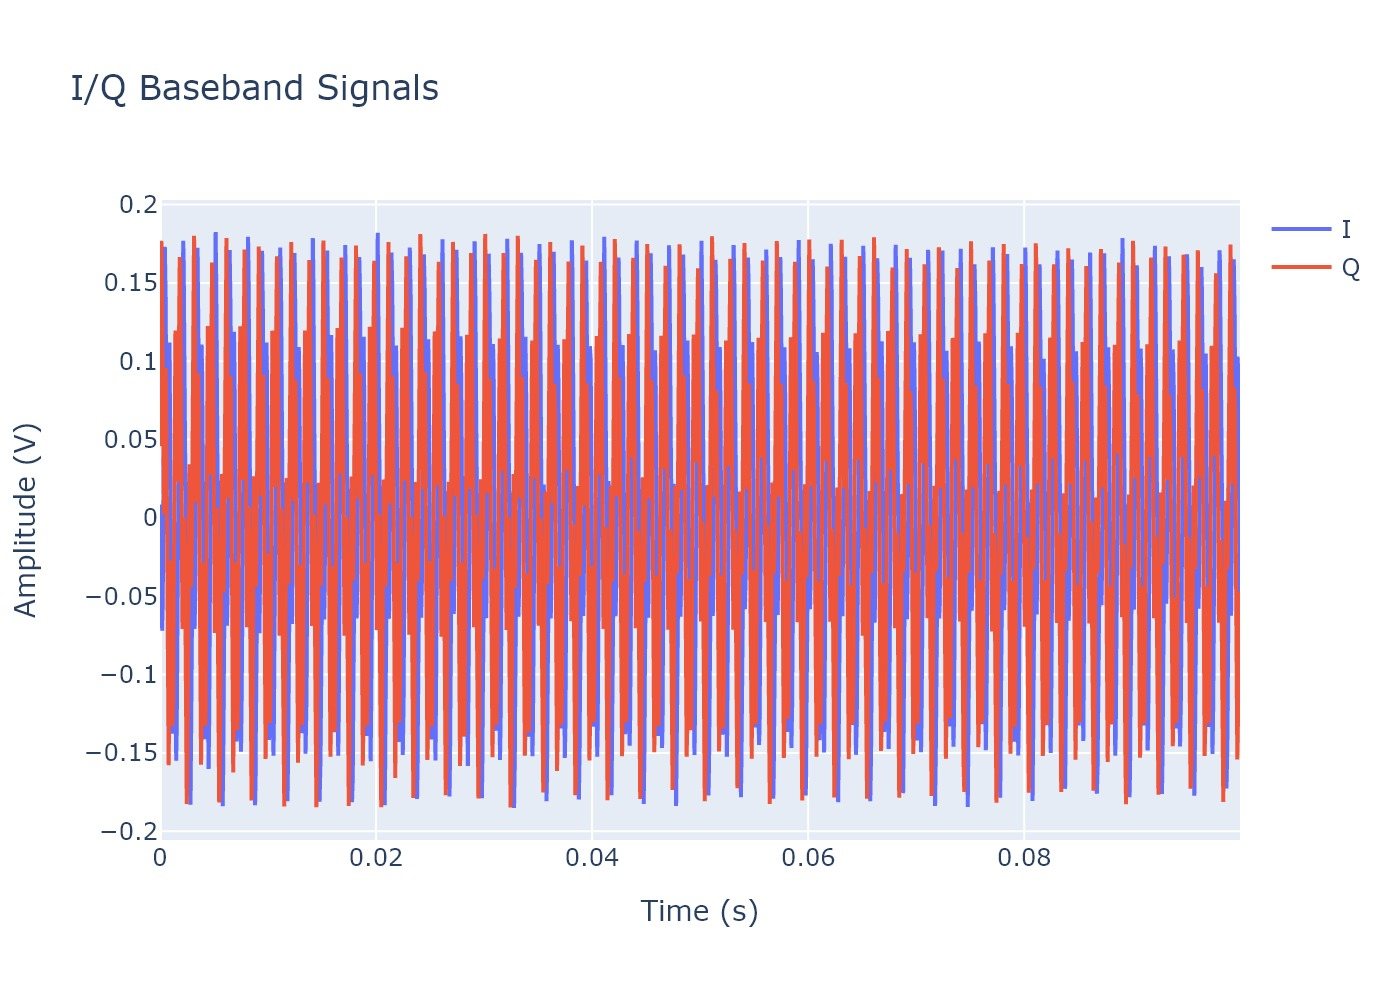

In [8]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=timestamp[0, 0, :],
        y=np.real(baseband[0, 0, :]),
        name="I",
    )
)
fig.add_trace(
    go.Scatter(
        x=timestamp[0, 0, :],
        y=np.imag(baseband[0, 0, :]),
        name="Q",
    )
)

fig.update_layout(
    title="I/Q Baseband Signals",
    yaxis=dict(title="Amplitude (V)"),
    xaxis=dict(title="Time (s)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Doppler Radar Signal Processing

We can use FFT to evaluate the frequency shifts introduced by the Doppler effect.


In [9]:
from scipy.fft import fft, fftshift
from scipy.constants import speed_of_light

spec = fftshift(fft(baseband[0, 0, :]))
speed = (
    np.linspace(
        -rx.bb_prop["fs"] / 2,
        rx.bb_prop["fs"] / 2,
        radar.sample_prop["samples_per_pulse"],
        endpoint=False,
    )
    * speed_of_light
    / 2
    / 10e9
)

_Plot the spectrum_


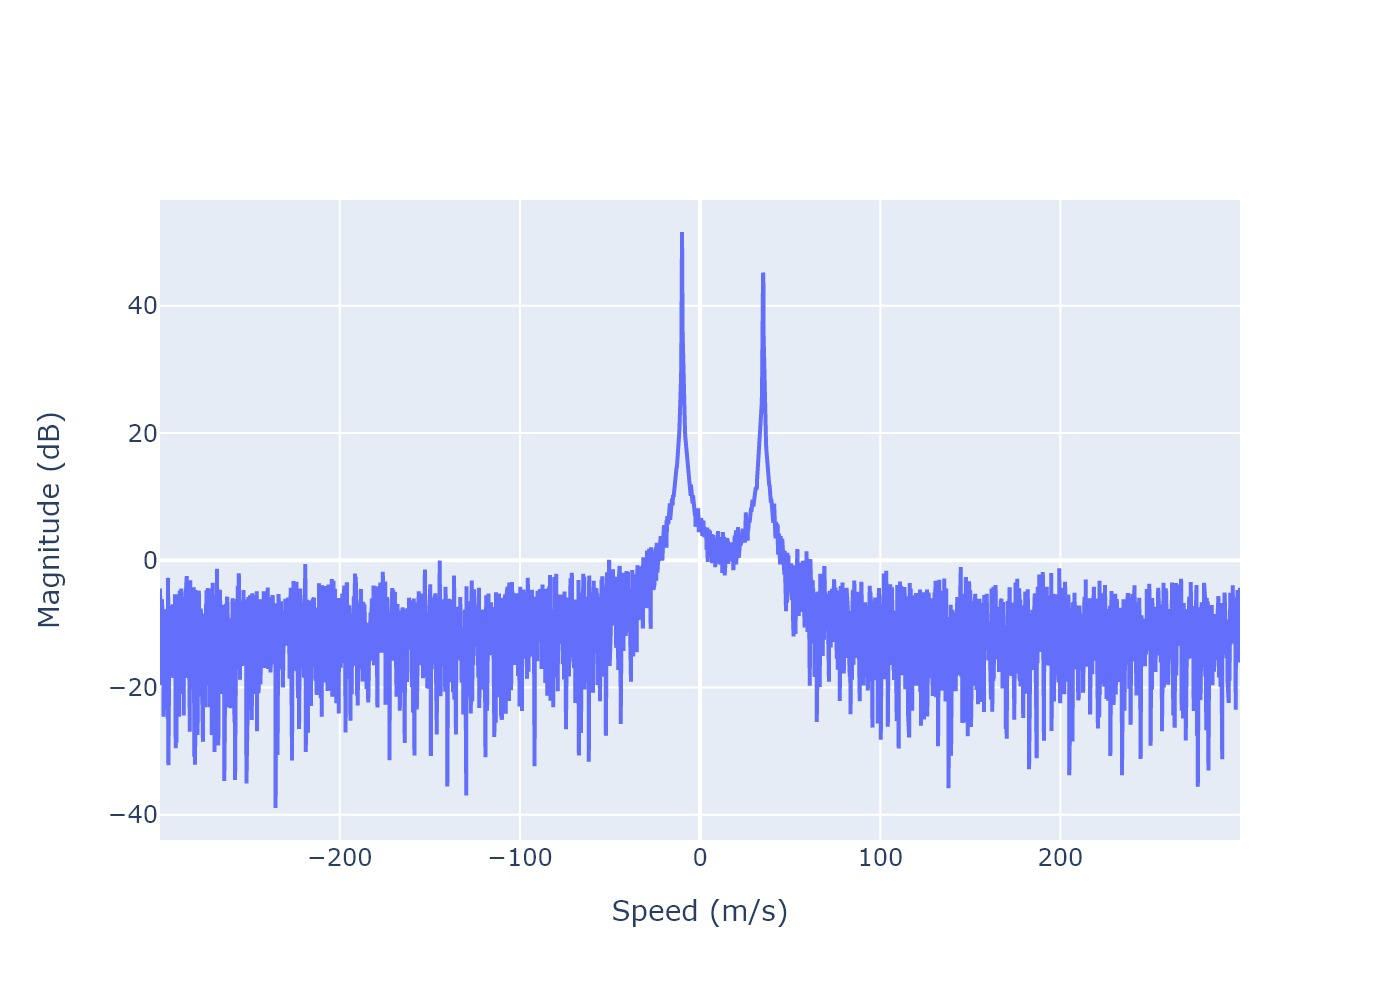

In [10]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=speed,
        y=20 * np.log10(np.abs(spec)),
    )
)
fig.update_layout(
    yaxis=dict(title="Magnitude (dB)"),
    xaxis=dict(title="Speed (m/s)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))